In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scienceplots

# Plotting Styles
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.style.use(["science", "ieee", "no-latex"])

In [2]:
# Load results from all experiments
df_nm_mismatched = pd.read_csv("data_ares/NM_mismatched.csv")
df_bo_mismatched = pd.read_csv("data_ares/BO_mismatched.csv")
df_bo_prior_mismatched = pd.read_csv("data_ares/BO_prior_mismatched.csv")
df_bo_prior_matched_newtask = pd.read_csv("data_ares/BO_prior_matched_prior_newtask.csv")
df_bo_prior_matched = pd.read_csv("data_ares/BO_prior_matched.csv")


In [3]:
# Find best MAE achieved across all methods
all_dfs = [df_nm_mismatched, df_bo_mismatched, df_bo_prior_mismatched, df_bo_prior_matched_newtask]
#all_dfs = [df_nm_mismatched, df_bo_mismatched, df_bo_prior_mismatched, df_bo_prior_matched]

global_best_mae = min([df['mae'].min() for df in all_dfs])

print(f"Best MAE found across all methods: {global_best_mae:.6e}")
print(f"Best MAE (mm): {global_best_mae * 1000:.4f}")

# Find which method achieved it
method_names = ['NM', 'BO', 'BO_prior (mismatched)', 'BO_prior (matched)']
for name, df in zip(method_names, all_dfs):
    if df['mae'].min() == global_best_mae: 
        print(f"Achieved by: {name}")

Best MAE found across all methods: 1.160512e-04
Best MAE (mm): 0.1161
Achieved by: BO_prior (matched)


C:\Users\HibaSikander\AppData\Local\Temp\ipykernel_2852\322281892.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{y*1000:.2f}" for y in yticks])


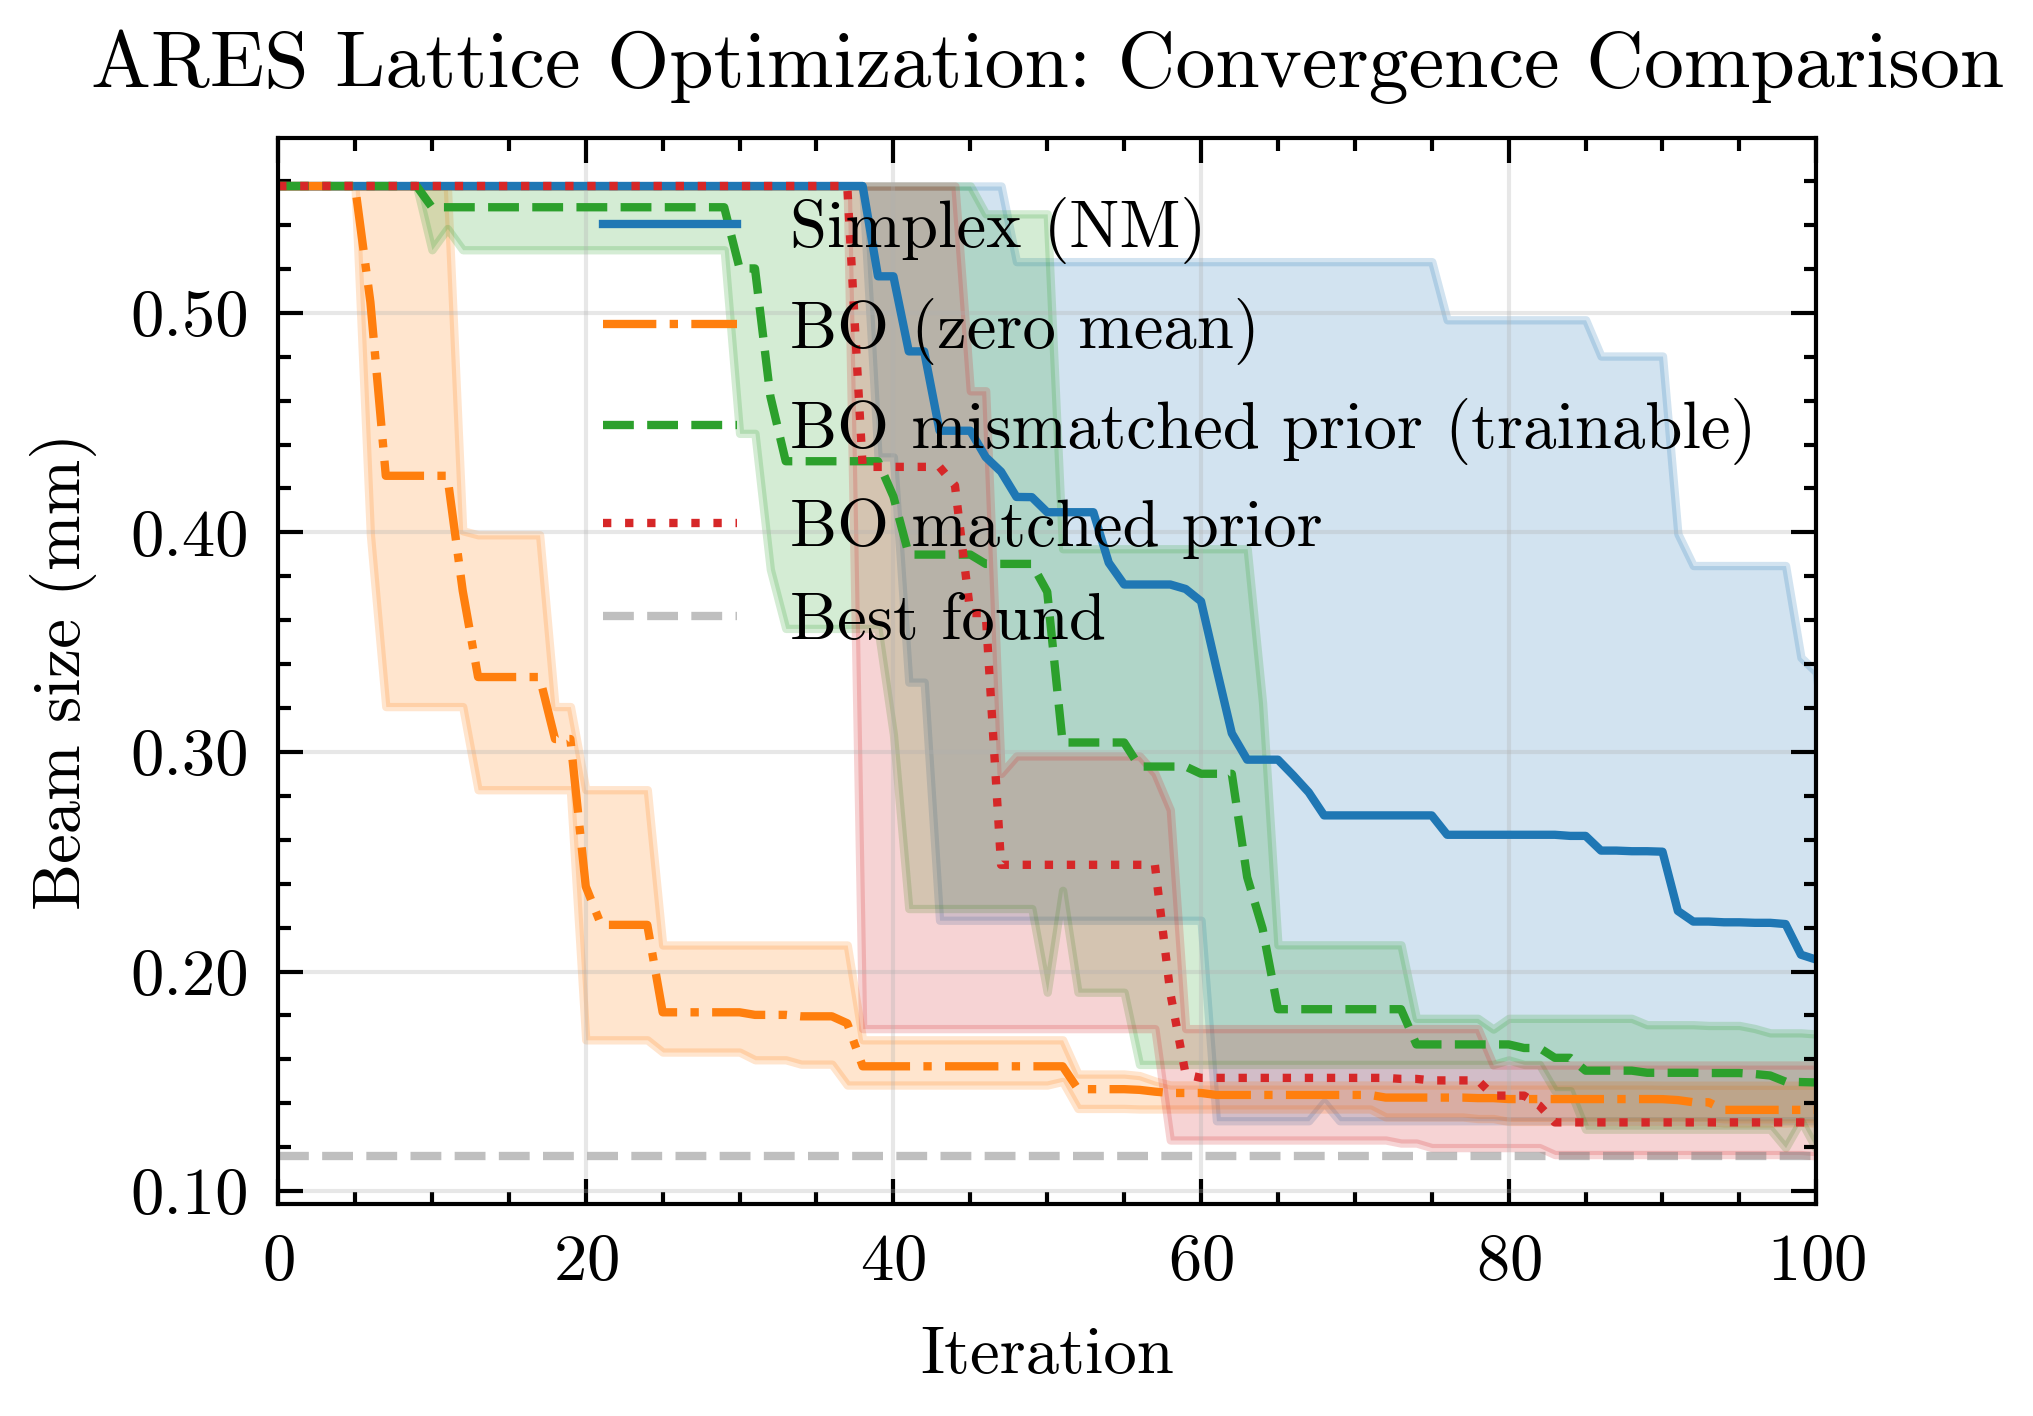

In [4]:
figsize = list(plt.rcParams["figure.figsize"])
fig = plt.figure(figsize=figsize)
ax = plt.gca()

# Plot convergence curves
sns.lineplot(
    data=df_nm_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="Simplex (NM)",
    color=colors[0],
    ls="-",
)
sns.lineplot(
    data=df_bo_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO (zero mean)",
    color=colors[1],
    ls="-.",
)
sns.lineplot(
    data=df_bo_prior_mismatched,
    x="step",
    y="best_mae",
    ax=ax,
    label="BO mismatched prior (trainable)",
    color=colors[2],
    ls="--",
)
sns.lineplot(
    data=df_bo_prior_matched_newtask,
    #data=df_bo_prior_matched,

    x="step",
    y="best_mae",
    ax=ax,
    label="BO matched prior",
    color=colors[3],
    ls=":",
)

# Add reference line for best found
ax.axhline(y=global_best_mae, color="grey", linestyle="--", alpha=0.5, label="Best found")

# Format y-axis to show mm
yticks = ax.get_yticks()
ax.set_yticklabels([f"{y*1000:.2f}" for y in yticks])
ax.set_ylabel("Beam size (mm)")
ax.set_xlabel("Iteration")
ax.set_title("ARES Lattice Optimization: Convergence Comparison")
ax.set_xlim(0, 100)
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("ares_bo_prior_result.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [5]:
# Calculate statistics for each method
def compute_stats(df, name):
    final_best = df.groupby('run')['best_mae'].last()
    print(f"\n{name}:")
    print(f"  Mean final best MAE:  {final_best.mean():.6e} ({final_best.mean()*1000:.4f} mm)")
    print(f"  Std final best MAE: {final_best.std():.6e} ({final_best.std()*1000:.4f} mm)")
    print(f"  Min final best MAE: {final_best.min():.6e} ({final_best.min()*1000:.4f} mm)")
    print(f"  Max final best MAE: {final_best.max():.6e} ({final_best.max()*1000:.4f} mm)")
    
    # Count how many runs reached within 10% of global best
    threshold = global_best_mae * 1.1
    success_rate = (final_best <= threshold).sum() / len(final_best) * 100
    print(f"  Success rate (within 10% of best): {success_rate:.1f}%")

compute_stats(df_nm_mismatched, "Nelder-Mead")
compute_stats(df_bo_mismatched, "BO (zero mean)")
compute_stats(df_bo_prior_mismatched, "BO mismatched prior")
compute_stats(df_bo_prior_matched_newtask, "BO matched prior")
#compute_stats(df_bo_prior_matched, "BO matched prior")




Nelder-Mead:
  Mean final best MAE:  2.044640e-04 (0.2045 mm)
  Std final best MAE: 1.119615e-04 (0.1120 mm)
  Min final best MAE: 1.320543e-04 (0.1321 mm)
  Max final best MAE: 3.334212e-04 (0.3334 mm)
  Success rate (within 10% of best): 0.0%

BO (zero mean):
  Mean final best MAE:  1.359832e-04 (0.1360 mm)
  Std final best MAE: 1.077746e-05 (0.0108 mm)
  Min final best MAE: 1.279679e-04 (0.1280 mm)
  Max final best MAE: 1.482352e-04 (0.1482 mm)
  Success rate (within 10% of best): 0.0%

BO mismatched prior:
  Mean final best MAE:  1.470356e-04 (0.1470 mm)
  Std final best MAE: 2.543174e-05 (0.0254 mm)
  Min final best MAE: 1.192155e-04 (0.1192 mm)
  Max final best MAE: 1.690885e-04 (0.1691 mm)
  Success rate (within 10% of best): 33.3%

BO matched prior:
  Mean final best MAE:  1.311001e-04 (0.1311 mm)
  Std final best MAE: 2.287045e-05 (0.0229 mm)
  Min final best MAE: 1.160512e-04 (0.1161 mm)
  Max final best MAE: 1.574183e-04 (0.1574 mm)
  Success rate (within 10% of best): 66.7

In [6]:
# Calculate how many iterations to reach certain thresholds
threshold = global_best_mae * 1.2  # 20% above best

def iterations_to_threshold(df, threshold):
    """Calculate iterations needed to reach threshold for each run"""
    iterations = []
    for run_id in df['run'].unique():
        run_data = df[df['run'] == run_id]
        below_threshold = run_data[run_data['best_mae'] <= threshold]
        if len(below_threshold) > 0:
            iterations.append(below_threshold.index[0] - run_data.index[0])
        else:
            iterations.append(np.nan)  # Never reached
    return iterations

print(f"\nIterations to reach {threshold*1000:.4f} mm:")
for name, df in zip(method_names, all_dfs):
    iters = iterations_to_threshold(df, threshold)
    valid_iters = [i for i in iters if not np.isnan(i)]
    if valid_iters:
        print(f"{name}: {np.mean(valid_iters):.1f} ± {np.std(valid_iters):.1f} iterations ({len(valid_iters)}/{len(iters)} runs)")
    else:
        print(f"{name}: Never reached threshold")


Iterations to reach 0.1393 mm:
NM: 61.0 ± 0.0 iterations (1/3 runs)
BO: 73.0 ± 21.0 iterations (2/3 runs)
BO_prior (mismatched): 85.0 ± 0.0 iterations (1/3 runs)
BO_prior (matched): 70.5 ± 12.5 iterations (2/3 runs)
